# Fully parallelized transformer

Slides: https://docs.google.com/presentation/d/1-FK4ILh3DUY-0PVFnbI6er6XcPsj2xnXJQlN1mVlqXk/edit#slide=id.p

Overleaf: https://www.overleaf.com/read/cpdvccyxnykg#772391

TODOs
* right now you have this annoying array vs list problem for the tree map, how do get around?

## Transformer implementation

Note that we aren't doing causal masking right now.

In [ ]:
! pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import pdb

class TransformerLayer(eqx.Module):
    self_attn: eqx.nn.MultiheadAttention
    feed_forward: eqx.nn.MLP
    d_model: int

    def __init__(self, d_model, num_heads, d_ff, *, key):
        keys = jax.random.split(key, 4)
        self.self_attn = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=d_model,
            key=keys[0]
        )
        self.feed_forward = eqx.nn.MLP(
            in_size=d_model,
            out_size=d_model,
            width_size=d_ff,
            depth=2,
            activation=jax.nn.relu,
            key=keys[1]
        )
        self.d_model = d_model

    def __call__(self, x):
        # Self-attention with residual connection and layer norm
        attn_output = self.self_attn(x,x,x)  # Self-attention (Q=K=V=x)

        # Feed-forward network with residual connection and layer norm
        # print(f"the shape of input x is {x.shape}")
        ff_output = jax.vmap(self.feed_forward)(x) # (T, d_model)
        # print(f"the shape of output ff_output is {ff_output.shape}")
        return x + ff_output

class Transformer(eqx.Module):
    layers: list
    d_model: int

    def __init__(self, num_layers, d_model, num_heads, d_ff, *, key):
        keys = jax.random.split(key, num_layers + 1)
        self.layers = [
            TransformerLayer(d_model, num_heads, d_ff, key=keys[i + 1]) for i in range(num_layers)
        ]
        self.d_model = d_model

    def __call__(self, x):
        # Apply each Transformer layer sequentially
        # TODO: replace with jax.lax.scan (stil sequential, just runs faster)
        for layer in self.layers:
            x = layer(x) # (T, d_model)
        return x

    def parallel_call(self, x, num_iters=7):
        # will use DEER. seems like we'll use way more memory, but is there a way around this...
        T, D = x.shape
        states_guess = [jnp.zeros((T, D)) for _ in range(num_layers)]# list of length num_layer, each entry (T,d_model)
        all_states = deer(x, self.layers, states_guess, num_iters)
        return all_states

def deer(x, layers, states_guess, num_iters):
  """
  runs deer (fiddly logic in the rearrange)

  Args:
    x: (T, d) initial inputs to transformer stack
    layers: list of TransformerLayer objects (the functions that propagate information over the stack)
    states_guess: list of length num_layers of (T, D) shaped arrays
    num_iters: number of iterations to run for

  Todo:
    * einsums might be wrong
    * the associative scan might be slightly wrong
  """
  T,D = x.shape
  @jax.vmap
  def binary_op(q_i, q_j):
      """Binary operator for parallel scan of linear recurrence. Assumes a full Jacobian matrix A
      Args:
          q_i: tuple containing J_i and b_i at position i       (P,P), (P,)
          q_j: tuple containing J_j and b_j at position j       (P,P), (P,)
      Returns:
          new element ( A_out, Bu_out )
      """
      A_i, b_i = q_i
      A_j, b_j = q_j
      return A_j @ A_i, A_j @ b_i + b_j

  def step(states, args):
    """
    This step is a single deer iteration (will eventually be sequential scanned)
    Args:
      states: list of length num_layers of (T, D) shaped arrays
      args: None
    """
    states = [x] + states[:-1] # length num_layers
    fs = jnp.array(jax.tree.map(lambda x, f : f(x), states, layers)) # (num_layers, T,D) arrays, note that we keep states as a list so we can use jax.tree.map
    As = jnp.array(jax.tree.map(lambda x, f : jax.jacrev(f)(x), states, layers)) # (num_layers, T, D, T, D) tensors
    As = As.at[0].set(jnp.zeros((T, D, T, D)))
    # need to make the first A equal to zero
    states = jnp.array(states) # (num_layers, T,D)
    # do some rearranging
    flattened_states= jnp.reshape(states, (num_layers, T*D)) # (num_layers, T*D)
    flattened_As = jnp.reshape(As, (num_layers, T*D, T*D)) # (num_layers, T*D, T*D)
    flattened_fs = jnp.reshape(fs, (num_layers, T*D)) # (num_layers, T*D)
    bs = flattened_fs -jnp.einsum("tij,tj->ti", flattened_As, flattened_states) # (num_layers, T*D)

    # finally ready to evaluate linearized dynamics (in parallel)
    _, new_states = jax.lax.associative_scan(binary_op, (flattened_As, bs)) # parallel operation
    new_states = jnp.nan_to_num(new_states)  # zero out nans, (num_layers, T*D)
    new_states = jnp.reshape(new_states, (num_layers, T, D)) # (num_layers, T, D)
    return list(new_states), new_states

  final_state, iter_hist = jax.lax.scan(step, states_guess, None, length=num_iters) # state_iters will show all the intermediate traces
  return iter_hist







In [ ]:
# Initialize Transformer with 100 layers
key = jax.random.PRNGKey(0)
num_layers = 100
d_model = 64
num_heads = 8
d_ff = 256

transformer_model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    key=key
)

# Example input for testing
T = 10
x = jax.random.normal(key, (T, d_model))  # (T,d_model)

## Can we accelerate with first order fixed point iterations?


In [ ]:
seq_output = transformer_model(x)

In [ ]:
parr_output = transformer_model.parallel_call(x, num_iters=7)

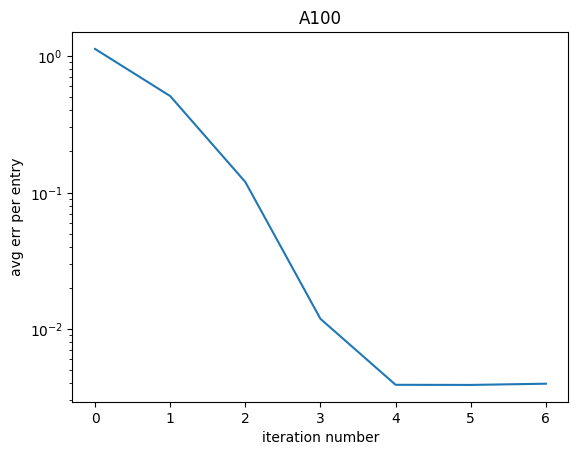

In [ ]:
plt.plot(jnp.mean(jnp.abs(seq_output - parr_output[:, -1]), axis=(1,2)))
plt.yscale('log')
plt.xlabel('iteration number')
plt.ylabel('avg err per entry')
plt.title("A100")
plt.show()

# Appendix

In [ ]:
# def deer_v1(x, layers, states_guess, num_iters):
#   """
#   runs deer (fiddling logic in the parallel scan)

#   Args:
#     x: (T, d) initial inputs to transformer stack
#     layers: list of TransformerLayer objects (the functions that propagate information over the stack)
#     states_guess: list of length num_layers of (T, D) shaped arrays
#     num_iters: number of iterations to run for

#   Todo:
#     * einsums might be wrong
#     * the associative scan might be slightly wrong
#   """
#   @jax.vmap
#   def binary_op(q_i, q_j):
#     A_i, b_i = q_i
#     A_j, b_j = q_j
#     # how do we do this Jacobian matrix multiply?
#     newA = jnp.einsum("tdse,seuf->tduf", A_i, A_j)
#     newB = jnp.einsum("tdse,td->tse", A_j, b_i) + b_j
#     return (newA, newB)

#   def step(states, args):
#     """
#     This step is a single deer iteration (will eventually be sequential scanned)
#     Args:
#       states: list of length num_layers of (T, D) shaped arrays
#       args: None
#     """
#     states = [x] + states[:-1] # length num_layers
#     fs = jnp.array(jax.tree.map(lambda x, f : f(x), states, layers)) # (num_layers, T,D) arrays, note that we keep states as a list so we can use jax.tree.map
#     As = jnp.array(jax.tree.map(lambda x, f : jax.jacrev(f)(x), states, layers)) # (num_layers, T, D, T, D) tensors
#     states = jnp.array(states) # (num_layers, T,D)
#     bs = fs - jnp.einsum("ltdse, ltd->lse", As, states) # (num_layers, T, D) # need to double check this
#     _, new_states = jax.lax.associative_scan(binary_op, (As, bs)) # parallel operation # I think I messed this up slightly, need to be a bit careful
#     new_states = jnp.nan_to_num(new_states)  # zero out nans, (num_layers, T, D)
#     return list(new_states), new_states

#   final_state, iter_hist = jax.lax.scan(step, states_guess, None, length=num_iters) # state_iters will show all the intermediate traces
#   return final_state
